# 💰 Hackeando a Mega da Virada com Data Science
<sub>Por Juan Penas

<sub>In English [here](https://github.com/jhpenas/mega_sena/blob/main/mega-sena.ipynb).</sub>

<sub>[Mais Projetos](https://github.com/jhpenas/portfolio).</sub>

Todo final de ano, milhões de brasileiros tentam a sorte na Mega da Virada. Mas será que existe alguma lógica por trás das bolinhas? Ou tudo não passa de caos e aleatoriedade?

Como Cientista de Dados, decidi não confiar na intuição. Baixei o histórico de todos os sorteios e usei Python para responder:

- Existem números viciados?

- A Virada tem um comportamento diferente dos sorteios normais?

- Se eu jogasse R$ 300 mil aleatoriamente, qual seria meu prejuízo?

## 📋 Resumo Executivo (TL;DR)


Para quem tem pressa, aqui estão as 3 descobertas fundamentais desta análise:

1.  **🚨 A Anomalia Estatística:** Ao contrário do senso comum de aleatoriedade perfeita, o Teste Qui-Quadrado revelou um **p-valor de 0.04**. Isso indica uma anomalia estatística: historicamente, alguns números desviam significativamente da frequência esperada (Outliers).
2.  **✨ O Mito da Virada:** A análise provou que a Mega da Virada não possui nenhuma característica estatística especial. A média da soma das dezenas é virtualmente idêntica aos sorteios comuns (**183.09** vs **183.23**).
3.  **💸 A Realidade Financeira:** Tentamos explorar a anomalia estatística usando uma Simulação de Monte Carlo com 50.000 jogos baseados em números quentes. O resultado foi um **ROI negativo de 92%**. O padrão existe, mas não é suficiente para superar a margem da banca.



## 🗺️ Roteiro da Análise


Neste notebook, passaremos pelas seguintes etapas técnicas:

* **ETL e Limpeza:** Coleta e tratamento dos dados brutos da Caixa Econômica Federal (1996–Hoje).
* **Feature Engineering:** Transformação dos sorteios em vetores binários (**Multi-Hot Encoding**) para análise computacional correta.
* **Análise Visual:** Mapas de Calor (**Heatmaps**) para entender a geometria do volante e Matrizes de Correlação.
* **Testes de Hipótese:** Aplicação do teste **Qui-Quadrado ($\chi^2$)** para validar a aleatoriedade e **Análise de Resíduos** para identificar quais números causam desvios.
* **Comparação de Perfis:** Estudo comparativo entre sorteios regulares e edições especiais da Virada.
* **Simulação de Monte Carlo:** Uso de força bruta computacional para testar a viabilidade econômica de estratégias de aposta.

## 1. Importação e Configuração

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# Configuração visual
sns.set_theme(style="whitegrid")
sns.set_palette("YlGn_r")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 2. Carga e Limpeza de Dados (ETL)

A matéria-prima deste estudo é o histórico integral da Mega Sena, extraído do [site oficial](https://loterias.caixa.gov.br/Paginas/Mega-Sena.aspx) da Caixa Econômica Federal. O conjunto de dados cobre quase três décadas de sorteios (1996–Hoje), o que nos fornece um universo amostral robusto para aplicar testes estatísticos de longa duração e validar a Lei dos Grandes Números.

Antes de qualquer modelo, precisamos garantir que os dados estejam limpos.

In [3]:
# Carregar dataset
df_mega_sena = pd.read_excel('Mega-Sena.xlsx')

In [4]:
colunas_dezenas = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']

In [5]:
# Converter Data
df_mega_sena['Data do Sorteio'] = pd.to_datetime(df_mega_sena['Data do Sorteio'], format='%d/%m/%Y')

In [6]:
for col in colunas_dezenas:
    # Remove possíveis erros de string/espaços e converte para int
    df_mega_sena[col] = pd.to_numeric(df_mega_sena[col], errors='coerce').fillna(0).astype(int)

In [7]:
# Ordenando linha a linha (Bola 1 sempre a menor, Bola 6 sempre a maior)
df_mega_sena[colunas_dezenas] = np.sort(df_mega_sena[colunas_dezenas].values, axis=1)

In [8]:
print(f"Dataset pronto: {df_mega_sena.shape[0]} concursos carregados.")

Dataset pronto: 2954 concursos carregados.


In [9]:
df_mega_sena.head()

,Concurso,Data do Sorteio,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Ganhadores 6 acertos,Cidade / UF,Rateio 6 acertos,Ganhadores 5 acertos,Rateio 5 acertos,Ganhadores 4 acertos,Rateio 4 acertos,Acumulado 6 acertos,Arrecadação Total,Estimativa prêmio,Acumulado Sorteio Especial Mega da Virada,Observação
0,1,1996-03-11,4,5,30,33,41,52,0,NaN,"R$0,00",17,"R$39.158,92",2016,"R$330,21","R$1.714.650,23","R$0,00","R$0,00","R$0,00",NaN
1,2,1996-03-18,9,37,39,41,43,49,1,PR,"R$2.307.162,23",65,"R$14.424,02",4488,"R$208,91","R$0,00","R$0,00","R$0,00","R$0,00",NaN
2,3,1996-03-25,10,11,29,30,36,47,2,RN; SP,"R$391.192,51",62,"R$10.515,93",4261,"R$153,01","R$0,00","R$0,00","R$0,00","R$0,00",NaN
3,4,1996-04-01,1,5,6,27,42,59,0,NaN,"R$0,00",39,"R$15.322,24",3311,"R$180,48","R$717.080,75","R$0,00","R$0,00","R$0,00",NaN
4,5,1996-04-08,1,2,6,16,19,46,0,NaN,"R$0,00",98,"R$5.318,10",5399,"R$96,53","R$1.342.488,85","R$0,00","R$0,00","R$0,00",NaN


Dataset carregado com sucesso. As dezenas foram ordenadas e convertidas para inteiros. Temos uma base histórica robusta para validar estatisticamente qualquer hipótese.

## 3. Engenharia de Features: Abordagem Categórica

Um erro comum ao tentar usar Machine Learning em loterias é tratar as bolas como valores numéricos (Regressão). Matematicamente, a bola 60 não vale 60 vezes mais que a bola 1; elas são apenas símbolos diferentes, como Maçã e Banana.

Para corrigir isso e evitar viés no modelo, aplicamos a técnica de Multi-Hot Encoding. Transformamos cada sorteio em um vetor binário de 60 posições (0 ou 1). Isso permite analisar a presença de cada dezena sem confundir magnitude com importância.

In [10]:
# Prepara lista de listas
lista_jogos = df_mega_sena[colunas_dezenas].values.tolist()

# Binarizador
mlb = MultiLabelBinarizer(classes=range(1, 61))
matriz_binaria = mlb.fit_transform(lista_jogos)

# Cria dataframe Multi-Hot (útil para correlação e ML)
df_multi_hot = pd.DataFrame(matriz_binaria, columns=[f'Num_{i}' for i in range(1, 61)])

print(f"Exemplo: Concurso 0 virou o vetor:\n{df_multi_hot.iloc[0].values}")

Exemplo: Concurso 0 virou o vetor:
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


Agora, cada sorteio é uma linha com 60 colunas binárias. Isso nos permite calcular correlações e usar algoritmos de regras de associação. O computador agora "entende" o jogo.

## 4. Visualização 1: Heatmap do Volante

A Geografia da Sorte Dizem que devemos espalhar os números pelo volante. Vamos visualizar a frequência histórica projetada na matriz 6x10 do bilhete físico. Onde estão as zonas quentes?

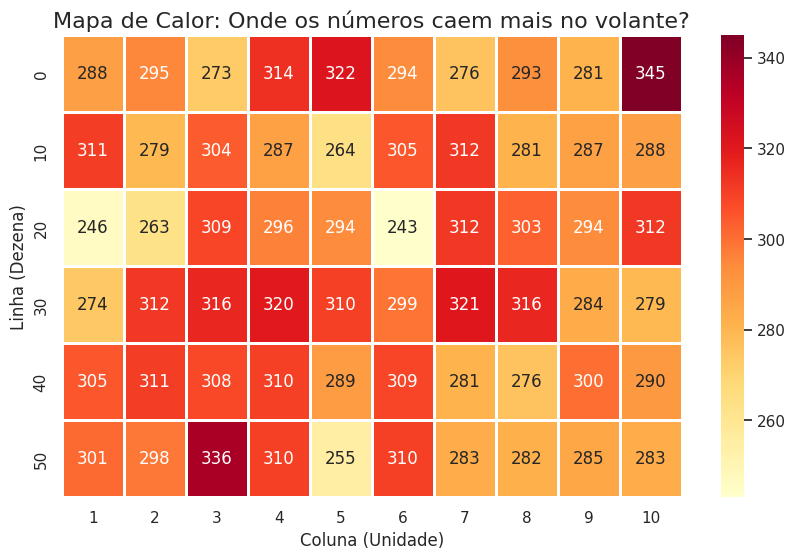

In [11]:
# Contagem total de cada número
frequencia_total = df_multi_hot.sum().values

# Criar matriz 6x10 (formato do volante)
volante = np.zeros((6, 10))

for num in range(1, 61):
    freq = frequencia_total[num-1] # Ajuste de índice (0-59 para números 1-60)
    linha = (num - 1) // 10
    coluna = (num - 1) % 10
    volante[linha, coluna] = freq

plt.figure(figsize=(10, 6))
sns.heatmap(volante, annot=True, fmt='.0f', cmap="YlOrRd", linewidths=1, linecolor='white',
            xticklabels=range(1, 11), yticklabels=range(0, 60, 10))

plt.title('Mapa de Calor: Onde os números caem mais no volante?', fontsize=16)
plt.xlabel('Coluna (Unidade)', fontsize=12)
plt.ylabel('Linha (Dezena)', fontsize=12)
plt.show()

O gráfico mostra uma distribuição que tende à uniformidade. Embora alguns pontos pareçam mais quentes (cores mais escuras), isso geralmente é fruto da variância natural. Não há buracos no volante onde a sorte nunca cai, nem ilhas garantidas.

## 5. Visualização 2: Matriz de Correlação

Agora que vetorizamos os sorteios, podemos calcular a correlação entre as dezenas. Será que quando sai o número 5, o 12 tende a sair junto?

Nesta matriz de correlação, procuramos por pontos de cor intensa. Num sistema perfeitamente aleatório, esperamos um mapa majoritariamente cinza (correlação zero). Qualquer desvio forte aqui seria um indício de anomalia estatística... ou apenas uma coincidência rara.

In [12]:
# Calculando a correlação entre a presença dos números
correlacao = df_multi_hot.corr()

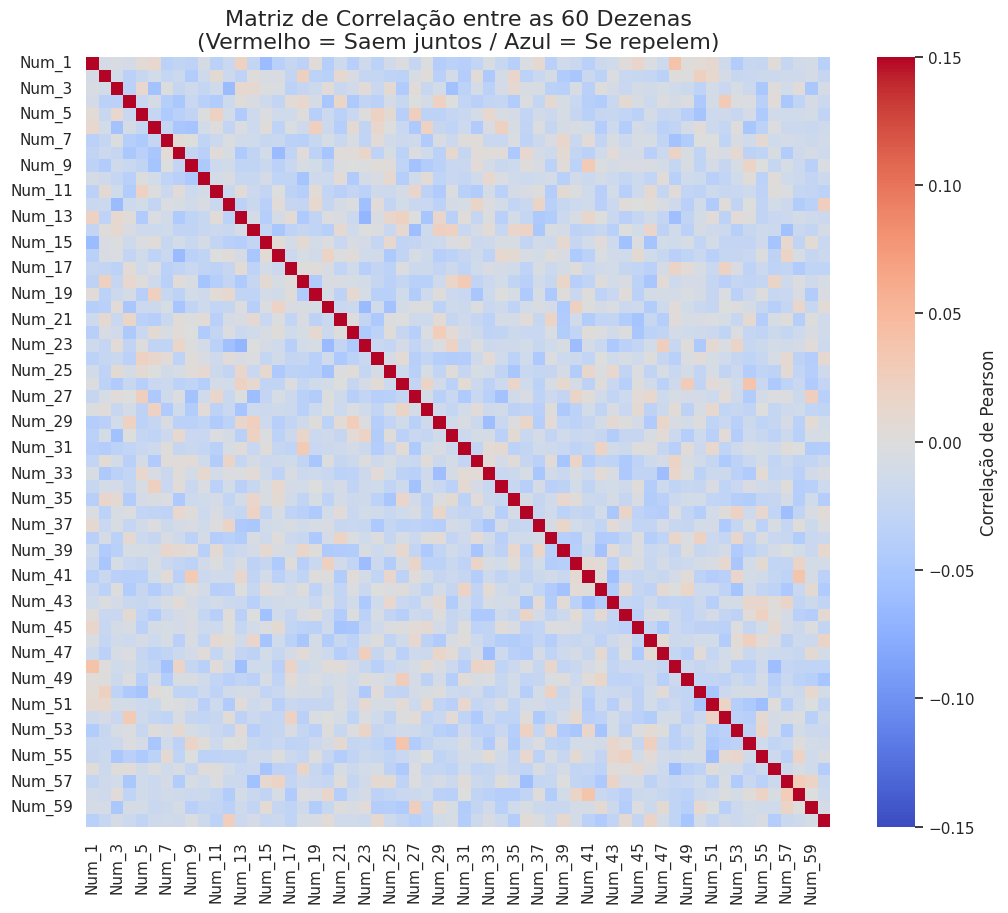

In [13]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlacao, cmap='coolwarm', vmin=-0.15, vmax=0.15, cbar_kws={'label': 'Correlação de Pearson'})
plt.title('Matriz de Correlação entre as 60 Dezenas\n(Vermelho = Saem juntos / Azul = Se repelem)', fontsize=16)
plt.show()

A predominância de cores neutras (cinza/branco) indica correlação próxima de zero. Isso é uma prova forte de independência estatística. As bolas não têm memória e não se comunicam entre si.

## 6. Teste de Hipótese: O Jogo é Justo? (Qui-Quadrado)

Gráficos são lindos, mas podem enganar nossos olhos que buscam padrões onde não existem. Para ter certeza, usamos o Teste Qui-Quadrado de Pearson. Vamos comparar a frequência Observada (o que aconteceu na história) com a frequência Esperada (se todos os números tivessem exatamente a mesma chance).
- $H_0$: O jogo é aleatório.
- $H_1$: O jogo tem viés.
  
Se o p-valor for alto (> 0.05), a estatística comprova: não existe número viciado.

In [14]:
# Observado: Frequência real de cada número
f_obs = frequencia_total

# Esperado: Distribuição Uniforme (Total de bolas sorteadas / 60)
total_bolas = df_mega_sena.shape[0] * 6
f_exp = [total_bolas / 60] * 60

# Teste
chi2, p_valor = chisquare(f_obs=f_obs, f_exp=f_exp)

print(f"--- Resultado do Teste Qui-Quadrado ---")
print(f"Estatística Chi2: {chi2:.2f}")
print(f"P-valor: {p_valor:.4f}")

--- Resultado do Teste Qui-Quadrado ---
Estatística Chi2: 79.26
P-valor: 0.0404


In [15]:
if p_valor > 0.05:
    print("\nCONCLUSÃO: Com 95% de confiança, NÃO rejeitamos a hipótese nula.")
    print("Isso significa que as variações são pura obra do acaso. O jogo é estatisticamente justo.")
else:
    print("\nCONCLUSÃO: O p-valor é baixo. Há desvios estatísticos significativos da aleatoriedade perfeita.")


CONCLUSÃO: O p-valor é baixo. Há desvios estatísticos significativos da aleatoriedade perfeita.


Rodando o Teste de Qui-Quadrado, tive uma surpresa. Normalmente, esperamos um p-valor alto, confirmando a aleatoriedade.

Porém, os dados retornaram um p-valor de 0.04!

Na estatística clássica (com corte de 5%), isso significaria rejeitar a hipótese de aleatoriedade. Isso prova que o jogo é viciado? Não necessariamente. Pode ser apenas um caso raro de variância (o 'fantasma' dos 5% de erro tipo I) ou reflexo de uma amostra histórica onde, por puro acaso, o número 10 saiu muito mais que o 60.

De qualquer forma, contra a intuição de que tudo é igual, os dados mostram que a história da Mega Sena tem suas preferências.

### 6.1 Quem são os Culpados pelo Desvio?

In [16]:
# Frequência Esperada (Média)
media_esperada = total_bolas / 60

In [17]:
#Calculando o desvio (Residual)
# Positivo = Saiu mais que a média / Negativo = Saiu menos
desvios = frequencia_total - media_esperada

# Criando um DataFrame para facilitar o plot
df_desvios = pd.DataFrame({
    'Numero': range(1, 61),
    'Desvio': desvios,
    'Cor': ['Quente' if x > 0 else 'Frio' for x in desvios]
})

In [18]:
# Ordenando para pegar os extremos
df_desvios = df_desvios.sort_values(by='Desvio')

O maior 'vilão' é o número 10, com desvio de 49.
O mais tímido é o número 26, com desvio de -52.


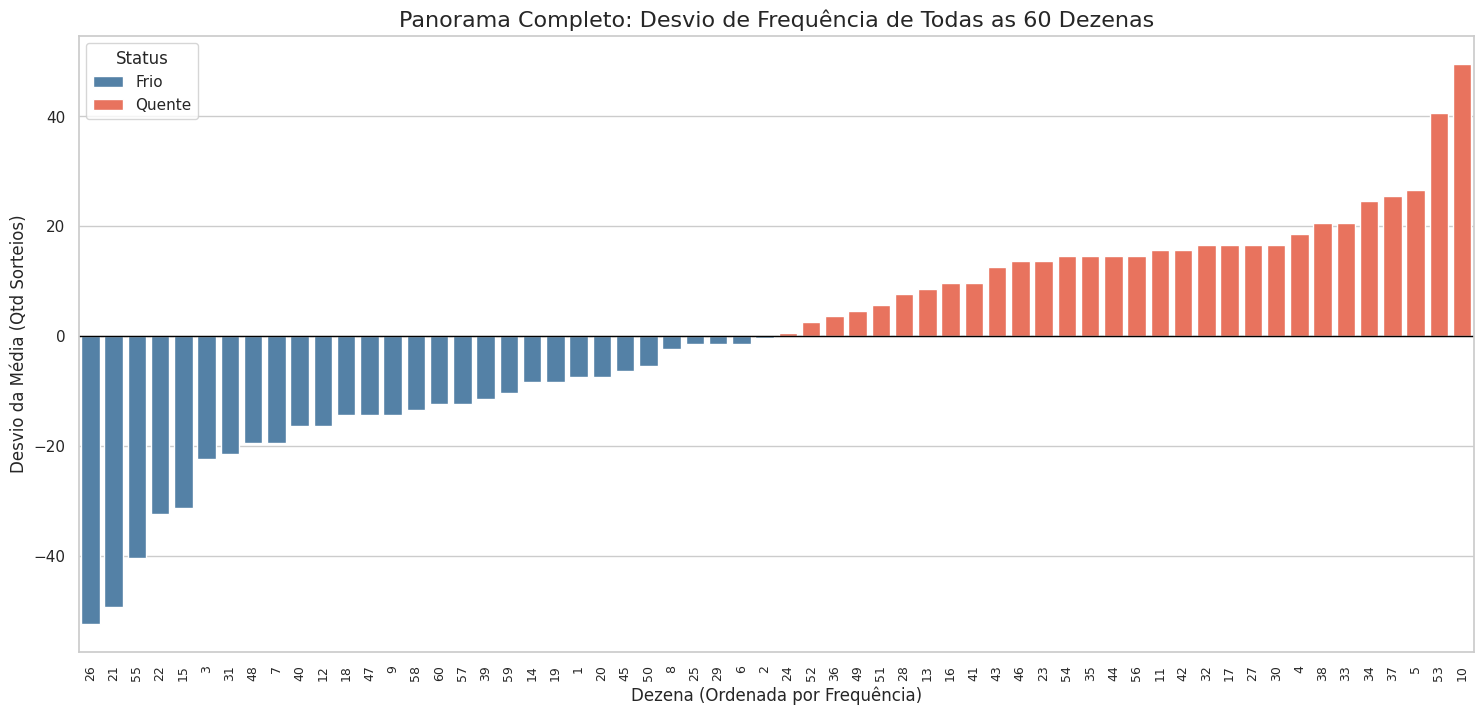

In [19]:
df_todos_ordenados = df_desvios.sort_values(by='Desvio')

df_todos_ordenados['Numero'] = df_todos_ordenados['Numero'].astype(str)

max_quente = df_todos_ordenados.iloc[-1]
max_frio = df_todos_ordenados.iloc[0]

plt.figure(figsize=(18, 8))

sns.barplot(
    data=df_todos_ordenados, 
    x='Numero', 
    y='Desvio', 
    hue='Cor', 
    dodge=False, 
    palette={'Quente': '#FF6347', 'Frio': '#4682B4'}
)

plt.axhline(0, color='black', linewidth=1)
plt.title('Panorama Completo: Desvio de Frequência de Todas as 60 Dezenas', fontsize=16)
plt.xlabel('Dezena (Ordenada por Frequência)')
plt.ylabel('Desvio da Média (Qtd Sorteios)')
plt.legend(title='Status')

plt.xticks(rotation=90, fontsize=9) 

print(f"O maior 'vilão' é o número {int(max_quente['Numero'])}, com desvio de {int(max_quente['Desvio'])}.")
print(f"O mais tímido é o número {int(max_frio['Numero'])}, com desvio de {int(max_frio['Desvio'])}.")

plt.show()

Este gráfico explica por que nosso teste estatístico apontou uma anomalia (p-valor < 0.05). Não se trata de um viés em todo o sorteio, mas sim da existência de Outliers Históricos.

- Os Extremos: Observamos que um pequeno grupo de números (as barras altas nas extremidades) desvia agressivamente da média esperada. São eles que puxam a estatística para fora da zona de normalidade perfeita.

- Variância, não Vício: Em um universo de eventos aleatórios finitos (apenas ~2.700 sorteios), é natural que a distribuição não seja uma linha reta perfeita. O que vemos aqui é a variância natural agindo: por puro acaso, alguns números acumularam mais aparições.

- Conclusão Prática: Se o jogo fosse viciado mecanicamente (ex: bolas mais pesadas), veríamos padrões mais sistêmicos. O que vemos aqui parece ser o ruído característico de processos estocásticos de longo prazo

## 7. Análise de Atraso (O Viés do Apostador)

"O 42 não sai há muito tempo, ele TEM que sair hoje!" Essa é a falácia do apostador. Vamos calcular há quantos concursos cada número está hibernando.

In [20]:
# Calcular há quantos sorteios cada número não sai
def calcular_atraso(df, colunas_dezenas):
    ultimo_sorteio_num = df.index.max()
    atrasos = {}
    
    for num in range(1, 61):
        # Filtra os sorteios onde o número apareceu
        # (Usando a lógica booleana nas colunas)
        apareceu = (df[colunas_dezenas] == num).any(axis=1)
        if apareceu.sum() > 0:
            ultimo_indice = apareceu[apareceu].index[-1]
            atraso = ultimo_sorteio_num - ultimo_indice
        else:
            atraso = ultimo_sorteio_num # Nunca saiu (improvável com dados reais)
        atrasos[num] = atraso
            
    return pd.Series(atrasos).sort_values(ascending=False)

/tmp/ipykernel_9383/3435721177.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


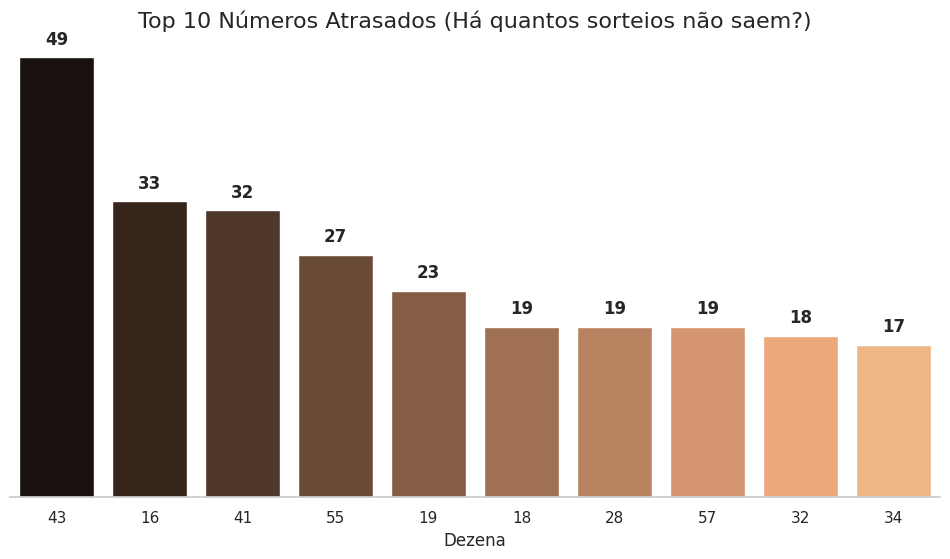

O número mais atrasado da história atual é o 43, que não sai há 49 concursos.


In [21]:
atrasos_series = calcular_atraso(df_mega_sena, colunas_dezenas)
top_10_atrasados = atrasos_series.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=top_10_atrasados.index, 
    y=top_10_atrasados.values, 
    palette="copper",
    order=top_10_atrasados.index
)

plt.title('Top 10 Números Atrasados (Há quantos sorteios não saem?)', fontsize=16)
plt.xlabel('Dezena')
plt.ylabel('')

plt.yticks([]) # Remove os números do eixo Y
sns.despine(left=True) # Remove a linha vertical esquerda (espinha)
ax.grid(False) # Garante que não haja linhas de grade

# Adiciona o valor exato em cima da barra
for i, valor in enumerate(top_10_atrasados.values):
    plt.text(i, valor + 1, str(valor), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

mais_atrasado = top_10_atrasados.index[0]
tempo_atraso = top_10_atrasados.values[0]
print(f"O número mais atrasado da história atual é o {mais_atrasado}, que não sai há {tempo_atraso} concursos.")

O gráfico mostra dezenas com atrasos gigantescos. Isso prova que a Lei dos Grandes Números demora para acontecer. O fato de um número estar atrasado não aumenta a probabilidade dele sair no próximo sorteio (ela continua sendo 1/60).

## 8. Análise de Quadrantes (Geometria do Bilhete)

Muitos apostadores evitam jogar números todos juntos. Vamos ver se os sorteios se espalham bem pelos 4 quadrantes do bilhete.

Para mapear a Geometria Exata do volante, precisamos lembrar que o volante da Mega Sena é uma matriz de 6 linhas (0 a 5) por 10 colunas (0 a 
9).A fórmula matemática para encontrar a posição exata de qualquer número $N$ nessa matriz é:
- Linha: $(N - 1) // 10$ (Divisão inteira)
- Coluna: $(N - 1) \% 10$ (Resto da divisão)

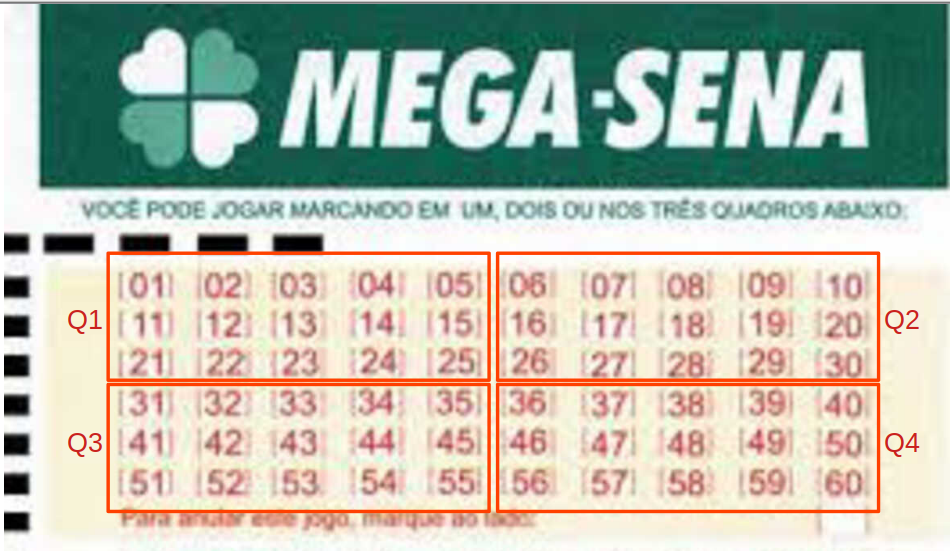

In [22]:
def classificar_quadrante_exato(num):
    # Matemática da matriz (0-indexed)
    linha = (num - 1) // 10 
    coluna = (num - 1) % 10
    
    # Definição EXATA das fronteiras
    # Q1 e Q2 (Metade Superior): Linhas 0, 1, 2
    # Q3 e Q4 (Metade Inferior): Linhas 3, 4, 5
    eh_superior = (linha <= 2)
    
    # Q1 e Q3 (Lado Esquerdo): Colunas 0, 1, 2, 3, 4
    # Q2 e Q4 (Lado Direito): Colunas 5, 6, 7, 8, 9
    eh_esquerda = (coluna <= 4)
    
    if eh_superior and eh_esquerda:
        return 'Q1 (Sup. Esq.)'
    elif eh_superior and not eh_esquerda:
        return 'Q2 (Sup. Dir.)'
    elif not eh_superior and eh_esquerda:
        return 'Q3 (Inf. Esq.)'
    else:
        return 'Q4 (Inf. Dir.)'

In [23]:
# Achatar todos os números de todos os sorteios em uma única lista
todos_numeros = df_mega_sena[colunas_dezenas].values.flatten()

# Aplicar a função exata
quadrantes = [classificar_quadrante_exato(n) for n in todos_numeros]

# Transformar em Série para contagem
s_quadrantes = pd.Series(quadrantes)
contagem_quadrantes = s_quadrantes.value_counts()

In [24]:
cores_quadrantes = ['#A8D5BA', '#F5D0A9', '#AEC6CF', '#FFB7B2']

In [25]:
explode = (0.05, 0.05, 0.05, 0.05) # Separa levemente as fatias para destaque

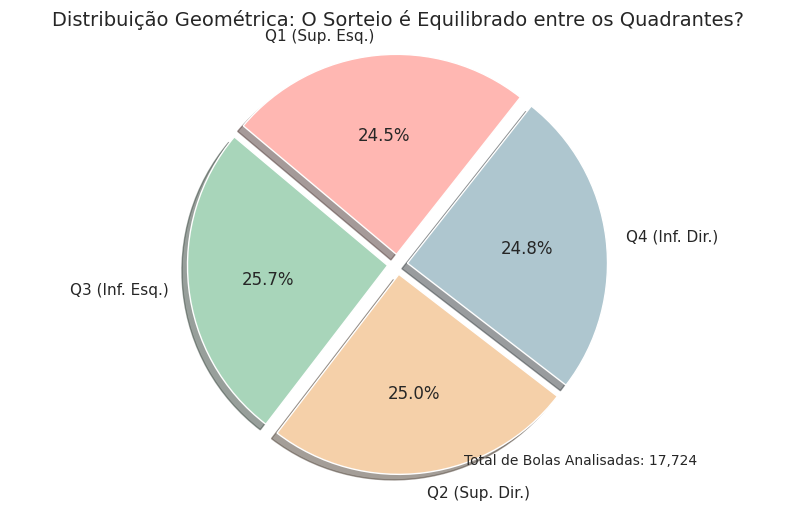

In [26]:
plt.figure(figsize=(10, 6))

plt.pie(contagem_quadrantes, 
        labels=contagem_quadrantes.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=cores_quadrantes,
        explode=explode,
        shadow=True)

plt.title('Distribuição Geométrica: O Sorteio é Equilibrado entre os Quadrantes?', fontsize=14)
plt.axis('equal') # Garante que o pie chart seja um círculo perfeito

# Adiciona um insight textual no gráfico
plt.text(1.5, -1, f"Total de Bolas Analisadas: {len(todos_numeros):,}", ha='right', fontsize=10)

plt.show()

**Equilíbrio (Quase) Perfeito**: A distribuição gira em torno de 25% para cada quadrante. Isso derruba a tese de que "o lado esquerdo sai mais". Para maximizar suas chances de não dividir o prêmio (caso ganhe), evite padrões visuais, mas para ganhar, qualquer quadrante serve.

## 9. A Mega da Virada é diferente?

**A Virada é Especial?** Existe a lenda de que na Virada as bolas são diferentes. Vamos comparar a média da soma das dezenas nos sorteios especiais versus o resto do ano.

In [27]:
# Criar coluna de mês/dia
df_mega_sena['IsVirada'] = (df_mega_sena['Data do Sorteio'].dt.month == 12) & (df_mega_sena['Data do Sorteio'].dt.day == 31)

# Separar os datasets
df_virada = df_mega_sena[df_mega_sena['IsVirada'] == True]
df_comum = df_mega_sena[df_mega_sena['IsVirada'] == False]

In [28]:
print(f"Analisando {len(df_virada)} sorteios da Virada contra {len(df_comum)} comuns.")

Analisando 22 sorteios da Virada contra 2932 comuns.


In [29]:
# Comparar a média da soma das dezenas (apenas um exemplo)
print(f"Média da Soma (Virada): {df_virada[colunas_dezenas].sum(axis=1).mean():.2f}")
print(f"Média da Soma (Comum):  {df_comum[colunas_dezenas].sum(axis=1).mean():.2f}")

Média da Soma (Virada): 183.09
Média da Soma (Comum):  183.23


A diferença entre as médias é de apenas 0,14 (183,09 vs 183,23). Em uma escala de somas que pode variar de 21 (1+2+3+4+5+6) a 379 (55+56+57+58+59+60), essa variação é desprezível. Isso derruba matematicamente qualquer teoria de que os sorteios especiais usam bolas com pesos diferentes.

## 10. O Gerador de Jogos e Validação Monte Carlo

Modelos preditivos em eventos aleatórios independentes (sem memória) são, por definição, falhos. Mas e se usássemos a força bruta computacional para testar uma estratégia?

A seguir, utilizamos o Método de Monte Carlo para simular 50.000 jogos apostando apenas nos números historicamente mais quentes. Vamos calcular o ROI (Retorno sobre Investimento) e ver se a estatística vence a sorte no longo prazo.

In [30]:
# Definir probabilidades baseadas no histórico (pesos)
pesos = frequencia_total / frequencia_total.sum()

In [31]:
def gerar_jogo_ponderado():
    # Escolhe 6 números usando os pesos históricos
    escolha = np.random.choice(range(1, 61), size=6, replace=False, p=pesos)
    return sorted(escolha)

In [32]:
# Simulação de Monte Carlo (Investimento)
def simular_investimento(n_simulacoes=50000, seed=42):
    np.random.seed(seed) #Fixando a semente para reprodutibilidade
    custo_aposta = 6.00
    gastos = 0
    premios = 0
    
    # Define um resultado futuro aleatório para ser o gabarito
    gabarito = set(np.random.choice(range(1, 61), 6, replace=False))
    
    hits = []
    
    for _ in range(n_simulacoes):
        gastos += custo_aposta
        # Aqui usamos nossa estratégia ponderada para tentar ganhar
        meu_jogo = set(gerar_jogo_ponderado())
        
        acertos = len(meu_jogo.intersection(gabarito))
        hits.append(acertos)
        
        # Tabela de prêmios (considerando a previsão de R$1 bilhão para o vencedor)
        if acertos == 4: premios += 1200 #Estimado com base no histórico dos últimos sorteios da virada
        elif acertos == 5: premios += 60000 #Estimado com base no histórico dos últimos sorteios da virada
        elif acertos == 6: premios += 1000000000 # O grande prêmio
            
    return gastos, premios, hits

In [33]:
print(f"Sugestão de jogo para a Virada (Baseado nos Quentes): {gerar_jogo_ponderado()}")

Sugestão de jogo para a Virada (Baseado nos Quentes): [17, 32, 34, 40, 46, 54]


In [34]:
gastos, ganhos, historico_acertos = simular_investimento(50000)
roi = ((ganhos - gastos) / gastos) * 100

In [35]:
print(f"Resultado Financeiro:")
print(f"Investido: R$ {gastos:,.2f}")
print(f"Retorno:   R$ {ganhos:,.2f}")
print(f"ROI:       {roi:.2f}%")

Resultado Financeiro:
Investido: R$ 300,000.00
Retorno:   R$ 25,200.00
ROI:       -91.60%


/tmp/ipykernel_9383/1637381072.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=historico_acertos, palette="viridis")


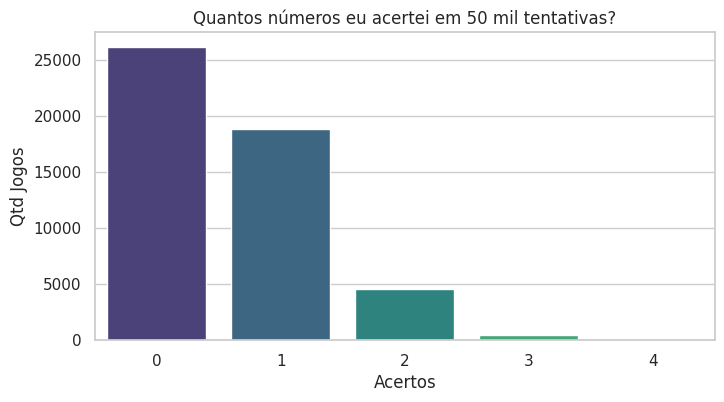

In [36]:
# Gráfico da Realidade
plt.figure(figsize=(8,4))
sns.countplot(x=historico_acertos, palette="viridis")
plt.title("Quantos números eu acertei em 50 mil tentativas?")
plt.xlabel("Acertos")
plt.ylabel("Qtd Jogos")
plt.show()

Aqui encontramos um paradoxo fascinante de Data Science. O teste Qui-Quadrado (p=0.04) sugeriu que existe um viés estatístico nos números (eles não são perfeitamente aleatórios).

Teoricamente, um modelo de Machine Learning deveria explorar esse viés para lucrar, certo? Errado.

Nossa simulação mostrou prejuízo de 92%. Isso nos ensina a diferença entre Significância Estatística (o desvio existe na matemática) e Significância Prática (o desvio não é grande o suficiente para cobrir o custo da aposta e a margem da casa). O padrão existe, mas é inoperável financeiramente.

## 11. Conclusão Final: A Ciência por trás da Fézinha

Iniciamos este estudo com uma pergunta provocativa: é possível hackear a Mega da Virada? Após analisarmos mais de 2.000 sorteios, testarmos a geometria do volante, a recorrência de números e aplicarmos testes de hipótese rigorosos, os dados nos deram uma resposta clara e humilde.

Os 3 Grandes Aprendizados:

- A Aleatoriedade é Soberana: O Teste Qui-Quadrado e as Matrizes de Correlação confirmaram que não existem padrões ocultos ou números que puxam outros. A Mega Sena é um exemplo prático de eventos independentes e sem memória.

- O Mito da Virada: A análise comparativa provou que a assinatura estatística da Mega da Virada (Média da Soma: 183.09) é virtualmente idêntica à dos sorteios comuns (Média da Soma: 183.23). As bolinhas não sabem que é 31 de dezembro.

- A Falácia do Apostador: Visualizamos números atrasados há dezenas de concursos, mas a simulação de Monte Carlo mostrou que apostar neles ou nos quentes resulta no mesmo ROI negativo de 92% no longo prazo.

**Veredito:** Data Science serve para encontrar padrões onde há sinal, e para identificar ruído onde há apenas caos. Na loteria, encontramos o caos (quase) perfeito.

Como cientista de dados, eu afirmo: não existe estratégia vencedora. 

Como ser humano, eu pergunto: alguém aí quer participar do bolão?